In [1]:
# Cell 1: Install dependencies
!pip install transformers datasets torch scikit-learn pandas numpy accelerate


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\medam\OneDrive\Dokumente\DevLab Pro\NPCTUNISIA\venv\Scripts\python.exe -m pip install --upgrade pip


In [1]:
# Cell 2: Import libraries
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset, DatasetDict
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch

c:\Users\medam\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cell 4: Load custom finance vocabulary
with open('../data/reference/tunisian_finance_vocab.json', 'r', encoding='utf-8') as f:
    finance_vocab = json.load(f)

In [3]:
from sklearn.model_selection import GroupShuffleSplit


# Load dataset
data = json.load(open("../data/reference/labeled_articles_v5.json", encoding="utf-8"))
df = pd.DataFrame(data)

# (Optional) quick sanity checks
assert {"text", "label", "group_id"}.issubset(df.columns), df.columns

# Group split to avoid leakage
texts  = df["text"].tolist()
labels = df["label"].tolist()
groups = df["group_id"].tolist()

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(texts, labels, groups))

train_df = df.iloc[train_idx].copy()
test_df  = df.iloc[test_idx].copy()

print(len(train_df), len(test_df))
print("Train distribution (raw):\n", train_df["label"].value_counts().sort_index())
print("Test distribution (raw):\n", test_df["label"].value_counts().sort_index())

# Map labels: -1→0, 0→1, 1→2 (required for num_labels=3)
label_map   = {-1: 0, 0: 1, 1: 2}
inverse_map = {0: -1, 1: 0, 2: 1}

train_df["label"] = train_df["label"].map(label_map)
test_df["label"]  = test_df["label"].map(label_map)

# Fail fast if anything wasn't mapped
if train_df["label"].isna().any() or test_df["label"].isna().any():
    bad_train = df.iloc[train_idx][df.iloc[train_idx]["label"].map(label_map).isna()]["label"].unique()
    bad_test  = df.iloc[test_idx][df.iloc[test_idx]["label"].map(label_map).isna()]["label"].unique()
    raise ValueError(f"Found unmapped labels. Bad train labels: {bad_train}, bad test labels: {bad_test}")

train_df["label"] = train_df["label"].astype(int)
test_df["label"]  = test_df["label"].astype(int)

print("Train distribution (mapped):\n", train_df["label"].value_counts().sort_index())
print("Test distribution (mapped):\n", test_df["label"].value_counts().sort_index())
print("Unique labels train/test:", sorted(train_df["label"].unique()), sorted(test_df["label"].unique()))


200 50
Train distribution (raw):
 label
-1    59
 0    71
 1    70
Name: count, dtype: int64
Test distribution (raw):
 label
-1    11
 0    19
 1    20
Name: count, dtype: int64
Train distribution (mapped):
 label
0    59
1    71
2    70
Name: count, dtype: int64
Test distribution (mapped):
 label
0    11
1    19
2    20
Name: count, dtype: int64
Unique labels train/test: [np.int64(0), np.int64(1), np.int64(2)] [np.int64(0), np.int64(1), np.int64(2)]


In [4]:
# Cell 6: Create Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])


In [5]:
# Cell 7: Initialize XLM-RoBERTa tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add custom finance tokens (important!)
new_tokens = (
    finance_vocab['entities'] + 
    finance_vocab['financial_terms_ar'] + 
    finance_vocab['financial_terms_fr']
)
tokenizer.add_tokens(new_tokens)

277

In [6]:
# Cell 8: Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'], 
        padding='max_length', 
        truncation=True,
        max_length=256  # Adjust based on article length
    )

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)


Map: 100%|██████████| 50/50 [00:00<00:00, 1975.11 examples/s]


In [7]:
# Cell 9: Load XLM-RoBERTa model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=inverse_map,
    label2id=label_map
)

# Resize embeddings for new tokens
model.resize_token_embeddings(len(tokenizer))

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(250260, 768, padding_idx=1)

In [8]:
# Cell 10: Training arguments (optimized for financial sentiment)
training_args = TrainingArguments(
    output_dir="./checkpoints/xlm-roberta-tunisian-finance",
    num_train_epochs=10,  # More epochs for 200 samples
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,              #warmup_steps=50,
    weight_decay=0.01,
    learning_rate=1e-5,  #change from 2e-5 to 1e-5 for better convergence on small dataset
    logging_dir='./checkpoints/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    seed=42
)


c:\Users\medam\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
# Cell 11: Metrics computation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    return {
        "accuracy": accuracy_score(labels, predictions),
        "report": classification_report(
            labels, 
            predictions, 
            target_names=['Negative', 'Neutral', 'Positive'],
            output_dict=True
        )
    }

In [10]:
# Check exact duplicates between train and test
overlap = set(train_df['text']) & set(test_df['text'])
print(f"Overlapping samples: {len(overlap)}")


Overlapping samples: 0


In [12]:
# Cell 12: Initialize Trainer
from transformers import EarlyStoppingCallback


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


C:\Users\medam\AppData\Local\Temp\ipykernel_20552\3938051043.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
# Cell 13: Train!
print("Starting fine-tuning...")
trainer.train()

Starting fine-tuning...


  0%|          | 0/250 [00:00<?, ?it/s]c:\Users\medam\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
  4%|▍         | 10/250 [02:09<51:19, 12.83s/it]

{'loss': 1.104, 'grad_norm': 4.4249162673950195, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.4}


  8%|▊         | 20/250 [04:17<49:17, 12.86s/it]

{'loss': 1.1021, 'grad_norm': 2.565528392791748, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.8}


 10%|█         | 25/250 [05:21<47:57, 12.79s/it]c:\Users\medam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\medam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\medam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

{'eval_loss': 1.0755518674850464, 'eval_accuracy': 0.4, 'eval_report': {'Negative': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11.0}, 'Neutral': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19.0}, 'Positive': {'precision': 0.4, 'recall': 1.0, 'f1-score': 0.5714285714285714, 'support': 20.0}, 'accuracy': 0.4, 'macro avg': {'precision': 0.13333333333333333, 'recall': 0.3333333333333333, 'f1-score': 0.19047619047619047, 'support': 50.0}, 'weighted avg': {'precision': 0.16, 'recall': 0.4, 'f1-score': 0.22857142857142854, 'support': 50.0}}, 'eval_runtime': 15.3198, 'eval_samples_per_second': 3.264, 'eval_steps_per_second': 0.457, 'epoch': 1.0}


c:\Users\medam\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
 12%|█▏        | 30/250 [06:54<54:15, 14.80s/it]  

{'loss': 1.0998, 'grad_norm': 8.959653854370117, 'learning_rate': 9.777777777777779e-06, 'epoch': 1.2}


 16%|█▌        | 40/250 [09:01<44:42, 12.78s/it]

{'loss': 1.09, 'grad_norm': 10.677447319030762, 'learning_rate': 9.333333333333334e-06, 'epoch': 1.6}


 20%|██        | 50/250 [11:07<41:52, 12.56s/it]

{'loss': 1.0942, 'grad_norm': 2.904555559158325, 'learning_rate': 8.888888888888888e-06, 'epoch': 2.0}


c:\Users\medam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\medam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\medam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

{'eval_loss': 1.0684491395950317, 'eval_accuracy': 0.4, 'eval_report': {'Negative': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11.0}, 'Neutral': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19.0}, 'Positive': {'precision': 0.4, 'recall': 1.0, 'f1-score': 0.5714285714285714, 'support': 20.0}, 'accuracy': 0.4, 'macro avg': {'precision': 0.13333333333333333, 'recall': 0.3333333333333333, 'f1-score': 0.19047619047619047, 'support': 50.0}, 'weighted avg': {'precision': 0.16, 'recall': 0.4, 'f1-score': 0.22857142857142854, 'support': 50.0}}, 'eval_runtime': 14.9652, 'eval_samples_per_second': 3.341, 'eval_steps_per_second': 0.468, 'epoch': 2.0}


c:\Users\medam\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
 24%|██▍       | 60/250 [13:40<40:35, 12.82s/it]  

{'loss': 1.0911, 'grad_norm': 9.358256340026855, 'learning_rate': 8.444444444444446e-06, 'epoch': 2.4}


 28%|██▊       | 70/250 [15:46<37:53, 12.63s/it]

{'loss': 1.0341, 'grad_norm': 6.564353942871094, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.8}


                                                
 30%|███       | 75/250 [17:05<37:10, 12.74s/it]

{'eval_loss': 0.9543888568878174, 'eval_accuracy': 0.66, 'eval_report': {'Negative': {'precision': 0.75, 'recall': 0.2727272727272727, 'f1-score': 0.4, 'support': 11.0}, 'Neutral': {'precision': 1.0, 'recall': 0.5263157894736842, 'f1-score': 0.6896551724137931, 'support': 19.0}, 'Positive': {'precision': 0.5555555555555556, 'recall': 1.0, 'f1-score': 0.7142857142857143, 'support': 20.0}, 'accuracy': 0.66, 'macro avg': {'precision': 0.7685185185185185, 'recall': 0.5996810207336524, 'f1-score': 0.6013136288998359, 'support': 50.0}, 'weighted avg': {'precision': 0.7672222222222222, 'recall': 0.66, 'f1-score': 0.6357832512315271, 'support': 50.0}}, 'eval_runtime': 15.7, 'eval_samples_per_second': 3.185, 'eval_steps_per_second': 0.446, 'epoch': 3.0}


c:\Users\medam\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
 32%|███▏      | 80/250 [18:22<41:54, 14.79s/it]  

{'loss': 1.0134, 'grad_norm': 7.403390407562256, 'learning_rate': 7.555555555555556e-06, 'epoch': 3.2}


 36%|███▌      | 90/250 [20:30<34:05, 12.78s/it]

{'loss': 0.9307, 'grad_norm': 11.145609855651855, 'learning_rate': 7.111111111111112e-06, 'epoch': 3.6}


 40%|████      | 100/250 [22:37<31:53, 12.76s/it]

{'loss': 0.8321, 'grad_norm': 10.537935256958008, 'learning_rate': 6.666666666666667e-06, 'epoch': 4.0}


                                                 
 40%|████      | 100/250 [22:53<31:53, 12.76s/it]

{'eval_loss': 0.7731846570968628, 'eval_accuracy': 0.76, 'eval_report': {'Negative': {'precision': 0.6666666666666666, 'recall': 0.36363636363636365, 'f1-score': 0.47058823529411764, 'support': 11.0}, 'Neutral': {'precision': 0.9375, 'recall': 0.7894736842105263, 'f1-score': 0.8571428571428571, 'support': 19.0}, 'Positive': {'precision': 0.6785714285714286, 'recall': 0.95, 'f1-score': 0.7916666666666666, 'support': 20.0}, 'accuracy': 0.76, 'macro avg': {'precision': 0.7609126984126983, 'recall': 0.70103668261563, 'f1-score': 0.7064659197012139, 'support': 50.0}, 'weighted avg': {'precision': 0.7743452380952381, 'recall': 0.76, 'f1-score': 0.7459103641456583, 'support': 50.0}}, 'eval_runtime': 15.3379, 'eval_samples_per_second': 3.26, 'eval_steps_per_second': 0.456, 'epoch': 4.0}


c:\Users\medam\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
 44%|████▍     | 110/250 [25:11<30:27, 13.06s/it]

{'loss': 0.7373, 'grad_norm': 9.456342697143555, 'learning_rate': 6.222222222222223e-06, 'epoch': 4.4}


 48%|████▊     | 120/250 [27:19<27:45, 12.81s/it]

{'loss': 0.7692, 'grad_norm': 8.036773681640625, 'learning_rate': 5.777777777777778e-06, 'epoch': 4.8}


                                                 
 50%|█████     | 125/250 [28:39<26:55, 12.92s/it]

{'eval_loss': 0.7382678985595703, 'eval_accuracy': 0.72, 'eval_report': {'Negative': {'precision': 0.6666666666666666, 'recall': 0.18181818181818182, 'f1-score': 0.2857142857142857, 'support': 11.0}, 'Neutral': {'precision': 1.0, 'recall': 0.7368421052631579, 'f1-score': 0.8484848484848485, 'support': 19.0}, 'Positive': {'precision': 0.6060606060606061, 'recall': 1.0, 'f1-score': 0.7547169811320755, 'support': 20.0}, 'accuracy': 0.72, 'macro avg': {'precision': 0.7575757575757575, 'recall': 0.6395534290271132, 'f1-score': 0.6296387051104032, 'support': 50.0}, 'weighted avg': {'precision': 0.769090909090909, 'recall': 0.72, 'f1-score': 0.6871681777342156, 'support': 50.0}}, 'eval_runtime': 15.4138, 'eval_samples_per_second': 3.244, 'eval_steps_per_second': 0.454, 'epoch': 5.0}


c:\Users\medam\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
 52%|█████▏    | 130/250 [29:54<29:32, 14.77s/it]

{'loss': 0.6856, 'grad_norm': 14.440227508544922, 'learning_rate': 5.333333333333334e-06, 'epoch': 5.2}


 56%|█████▌    | 140/250 [32:02<23:32, 12.84s/it]

{'loss': 0.6798, 'grad_norm': 7.83111572265625, 'learning_rate': 4.888888888888889e-06, 'epoch': 5.6}


 60%|██████    | 150/250 [34:09<21:08, 12.69s/it]

{'loss': 0.6337, 'grad_norm': 7.458036422729492, 'learning_rate': 4.444444444444444e-06, 'epoch': 6.0}


                                                 
 60%|██████    | 150/250 [34:24<21:08, 12.69s/it]

{'eval_loss': 0.7029910087585449, 'eval_accuracy': 0.62, 'eval_report': {'Negative': {'precision': 0.25, 'recall': 0.2727272727272727, 'f1-score': 0.2608695652173913, 'support': 11.0}, 'Neutral': {'precision': 0.8823529411764706, 'recall': 0.7894736842105263, 'f1-score': 0.8333333333333334, 'support': 19.0}, 'Positive': {'precision': 0.6190476190476191, 'recall': 0.65, 'f1-score': 0.6341463414634146, 'support': 20.0}, 'accuracy': 0.62, 'macro avg': {'precision': 0.5838001867413632, 'recall': 0.5707336523125996, 'f1-score': 0.5761164133380464, 'support': 50.0}, 'weighted avg': {'precision': 0.6379131652661064, 'recall': 0.62, 'f1-score': 0.6277165075998586, 'support': 50.0}}, 'eval_runtime': 15.0978, 'eval_samples_per_second': 3.312, 'eval_steps_per_second': 0.464, 'epoch': 6.0}


 60%|██████    | 150/250 [34:35<23:03, 13.83s/it]

{'train_runtime': 2075.2376, 'train_samples_per_second': 0.964, 'train_steps_per_second': 0.12, 'train_loss': 0.926466900507609, 'epoch': 6.0}


TrainOutput(global_step=150, training_loss=0.926466900507609, metrics={'train_runtime': 2075.2376, 'train_samples_per_second': 0.964, 'train_steps_per_second': 0.12, 'total_flos': 157868050636800.0, 'train_loss': 0.926466900507609, 'epoch': 6.0})

In [14]:
# Cell 14: Evaluate
results = trainer.evaluate()
print(f"\n{'='*60}")
print(f"Test Accuracy: {results['eval_accuracy']:.2%}")
print(f"{'='*60}")

c:\Users\medam\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Test Accuracy: 76.00%


In [2]:
import os, glob, json

out_dir = "./checkpoints/xlm-roberta-tunisian-finance"

print("Output dir exists:", os.path.exists(out_dir))
print("Checkpoint dirs:", glob.glob(os.path.join(out_dir, "checkpoint-*")))


Output dir exists: True
Checkpoint dirs: ['./checkpoints/xlm-roberta-tunisian-finance\\checkpoint-100', './checkpoints/xlm-roberta-tunisian-finance\\checkpoint-150']


In [3]:
state_files = glob.glob(os.path.join(out_dir, "checkpoint-*", "trainer_state.json"))
state_files = sorted(state_files, key=os.path.getmtime)

state = json.load(open(state_files[-1], encoding="utf-8"))
print("best_metric:", state.get("best_metric"))
print("best_model_checkpoint:", state.get("best_model_checkpoint"))


best_metric: 0.76
best_model_checkpoint: ./checkpoints/xlm-roberta-tunisian-finance\checkpoint-100


In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

best_ckpt = r"./checkpoints/xlm-roberta-tunisian-finance/checkpoint-100"

tokenizer = AutoTokenizer.from_pretrained(best_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(best_ckpt)

print("✓ Loaded best checkpoint:", best_ckpt)


c:\Users\medam\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Loaded best checkpoint: ./checkpoints/xlm-roberta-tunisian-finance/checkpoint-100


In [6]:
# Cell 15: Save model
model.save_pretrained("../src/models/xlm-roberta-tunisian-finance-final")
tokenizer.save_pretrained("../src/models/xlm-roberta-tunisian-finance-final")
print("✓ Model saved!")

✓ Model saved!


In [25]:
# Cell 17: Load the main scraped results
print("="*60)
print("SENTIMENT ANALYSIS ON SCRAPED ARTICLES")
print("="*60)

from pathlib import Path

input_file = '../data/processed/global_cleaned2.json'
with open(input_file, 'r', encoding='utf-8') as f:
    full_data = json.load(f)

# Extract articles from the structure
articles = full_data.get('all_articles', [])
print(f"✓ Loaded {len(articles)} articles for analysis")

# Preview structure
if articles:
    print("\nSample article structure:")
    sample = articles[0]
    print(f"Keys: {list(sample.keys())}")
    print(f"Sample headline: {sample.get('headline', 'N/A')[:80]}...")
    print(f"Sample tickers: {sample.get('tickers', 'N/A')}")

SENTIMENT ANALYSIS ON SCRAPED ARTICLES
✓ Loaded 2828 articles for analysis

Sample article structure:
Keys: ['id', 'headline', 'content', 'date', 'url', 'tickers', 'language']
Sample headline: qui est sami derbel, nouveau secrétaire général de la stb bank ?...
Sample tickers: ['STB']


In [26]:
# Cell 18: Initialize the sentiment analysis pipeline
from transformers import pipeline
import torch

model_path = "../src/models/xlm-roberta-tunisian-finance-final"

print(f"\n🤖 Loading trained model from: {model_path}")

# Create sentiment pipeline
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model=model_path,
    tokenizer=model_path,
    device=0 if torch.cuda.is_available() else -1,  # Use GPU if available
    max_length=256,
    truncation=True
)

print("✓ Model loaded successfully!")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")


🤖 Loading trained model from: ../src/models/xlm-roberta-tunisian-finance-final


Device set to use cpu


✓ Model loaded successfully!
Device: CPU


In [51]:
labels_map = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}

def parse_model_output(result):
    """
    Convert model prediction to sentiment score.
    The model already returns -1/0/1 directly, no mapping needed!
    """
    try:
        if isinstance(result, dict):
            label = result.get('label')
            
            # Label is already the sentiment score (-1, 0, or 1)
            if isinstance(label, (int, float)):
                # Ensure it's a valid sentiment score
                if label in [-1, 0, 1]:
                    return int(label)
                else:
                    print(f"⚠️ Unexpected label value: {label}")
                    return 0
            
            # Fallback: string format "LABEL_X"
            elif isinstance(label, str):
                if label == 'LABEL_0' or label == '-1':
                    return -1
                elif label == 'LABEL_1' or label == '0':
                    return 0
                elif label == 'LABEL_2' or label == '1':
                    return 1
        
        # Direct integer/float
        elif isinstance(result, (int, float)):
            if result in [-1, 0, 1]:
                return int(result)
        
        return 0
            
    except Exception as e:
        print(f"⚠️ Parse error: {e}, result={result}")
        return 0

print("✓ Label mapping configured - NO INVERSE MAPPING!")

# Test it
test_cases = [
    {'label': -1, 'score': 0.95},  # Negative
    {'label': 0, 'score': 0.85},   # Neutral
    {'label': 1, 'score': 0.73},   # Positive
]

for test in test_cases:
    parsed = parse_model_output(test)
    print(f"{test} → {parsed} ({labels_map[parsed]})")

✓ Label mapping configured - NO INVERSE MAPPING!
{'label': -1, 'score': 0.95} → -1 (Negative)
{'label': 0, 'score': 0.85} → 0 (Neutral)
{'label': 1, 'score': 0.73} → 1 (Positive)


In [65]:
# Cell 20: Return both labels and confidence scores
def predict_sentiments_batch(texts, batch_size=16, desc="Processing"):
    """
    Process texts in batches for efficiency.
    Returns: (list of sentiment scores, list of confidence scores)
    """
    from tqdm import tqdm
    
    sentiment_scores = []
    confidence_scores = []
    
    # Progress bar
    num_batches = (len(texts) + batch_size - 1) // batch_size
    
    for i in tqdm(range(0, len(texts), batch_size), total=num_batches, desc=desc):
        batch = texts[i:i+batch_size]
        
        # Prepare batch (handle empty/None texts)
        processed_batch = []
        valid_indices = []
        
        for idx, text in enumerate(batch):
            if text and isinstance(text, str) and len(text.strip()) >= 5:
                processed_batch.append(text[:512])
                valid_indices.append(idx)
        
        # Initialize with neutral/low confidence
        batch_sentiments = [0] * len(batch)
        batch_confidences = [0.0] * len(batch)
        
        try:
            if processed_batch:
                results = sentiment_analyzer(processed_batch)
                
                # Map results back to original batch positions
                for result_idx, batch_idx in enumerate(valid_indices):
                    result = results[result_idx]
                    sentiment_score = parse_model_output(result)
                    # Get the confidence score from the model
                    conf_score = result.get('score', 0.5) if isinstance(result, dict) else 0.5
                    
                    batch_sentiments[batch_idx] = sentiment_score
                    batch_confidences[batch_idx] = conf_score
                    
        except Exception as e:
            print(f"\n⚠️ Batch error at index {i}: {str(e)}")
        
        sentiment_scores.extend(batch_sentiments)
        confidence_scores.extend(batch_confidences)
    
    return sentiment_scores, confidence_scores

In [66]:
# Cell 21: Extract and prepare texts from articles
print("\n📝 Preparing texts for analysis...")

# Handle both string and list formats for content
headlines = []
contents = []

for article in articles:
    # Extract headline
    headline = article.get('headline', '')
    headlines.append(headline if headline else '')
    
    # Extract content (handle different formats)
    content = article.get('content', '')
    if isinstance(content, list):
        # Join list of paragraphs
        content = ' '.join([p for p in content if p])
    elif not isinstance(content, str):
        content = str(content) if content else ''
    
    contents.append(content)

print(f"✓ Prepared {len(headlines)} headlines")
print(f"✓ Prepared {len(contents)} content texts")

# Validate
empty_headlines = sum(1 for h in headlines if not h or len(h.strip()) < 5)
empty_contents = sum(1 for c in contents if not c or len(c.strip()) < 5)
print(f"  - Empty/short headlines: {empty_headlines}")
print(f"  - Empty/short contents: {empty_contents}")


📝 Preparing texts for analysis...
✓ Prepared 2828 headlines
✓ Prepared 2828 content texts
  - Empty/short headlines: 0
  - Empty/short contents: 0


In [67]:
# Cell 22: UPDATED - Get both scores and confidences
print("\n" + "="*60)
print("RUNNING SENTIMENT ANALYSIS")
print("="*60)

print("\n🤖 Analyzing Headlines (Primary Signal)...")
headline_scores, headline_confidences = predict_sentiments_batch(headlines, batch_size=16, desc="Headlines")

print("\n🔍 Analyzing Content (Detailed Context)...")
content_scores, content_confidences = predict_sentiments_batch(contents, batch_size=16, desc="Content")

print("\n✅ Inference completed!")



RUNNING SENTIMENT ANALYSIS

🤖 Analyzing Headlines (Primary Signal)...


Headlines: 100%|██████████| 177/177 [02:18<00:00,  1.28it/s]



🔍 Analyzing Content (Detailed Context)...


Content: 100%|██████████| 177/177 [08:56<00:00,  3.03s/it]


✅ Inference completed!


In [68]:
# Cell 23: ENHANCED - Combine model confidence with agreement logic
print("\n⚙️ Applying sentiment aggregation logic...")

for i, article in enumerate(articles):
    h_score = headline_scores[i]
    c_score = content_scores[i]
    h_conf = headline_confidences[i]
    c_conf = content_confidences[i]
    
    # COMBINED CONFIDENCE CALCULATION:
    # Base confidence = model's confidence score
    # Boost if both agree, penalize if they disagree
    
    if h_score != 0:
        # Headline has clear sentiment
        if c_score == h_score:
            # Both agree - use max confidence, boost by 10%
            final_sentiment = h_score
            confidence = min(1.0, max(h_conf, c_conf) * 1.1)
        elif c_score == 0:
            # Content is neutral - use headline confidence as-is
            final_sentiment = h_score
            confidence = h_conf
        else:
            # They disagree - use headline but penalize confidence by 30%
            final_sentiment = h_score
            confidence = h_conf * 0.7
    else:
        # Headline is neutral - use content
        final_sentiment = c_score
        if c_score != 0:
            confidence = c_conf * 0.8  # Slight penalty for neutral headline
        else:
            confidence = max(h_conf, c_conf) * 0.5  # Both neutral - low confidence
    
    # Store enriched results
    article['sentiment_score'] = int(final_sentiment)
    #article['sentiment_label'] = labels_map[final_sentiment]
    #article['headline_sentiment'] = int(h_score)
    #article['content_sentiment'] = int(c_score)
    #article['headline_confidence'] = round(h_conf, 3)
    #article['content_confidence'] = round(c_conf, 3)
    article['confidence'] = round(confidence, 3)

print("✅ Sentiment enrichment complete!")


⚙️ Applying sentiment aggregation logic...
✅ Sentiment enrichment complete!


In [69]:
# Cell 24: Preview results
print("\n" + "="*80)
print("SAMPLE RESULTS")
print("="*80)

for i, a in enumerate(articles[:5]):
    print(f"\n[Article {i+1}]")
    print(f"Date: {a.get('date', 'N/A')}")
    print(f"Source: {a.get('source', 'N/A')}")
    print(f"Tickers: {a.get('tickers', 'N/A')}")
    print(f"Headline: {a.get('headline', '')[:80]}...")
    print(f"  └─ Headline Sentiment: {labels_map[a['headline_sentiment']]}")
    print(f"  └─ Content Sentiment: {labels_map[a['content_sentiment']]}")
    print(f"  └─ Final Sentiment: {a['sentiment_label']} (confidence: {a['confidence']})")
    print("-"*80)


SAMPLE RESULTS

[Article 1]
Date: 2026-01-07
Source: N/A
Tickers: ['STB']
Headline: qui est sami derbel, nouveau secrétaire général de la stb bank ?...
  └─ Headline Sentiment: Neutral
  └─ Content Sentiment: Positive
  └─ Final Sentiment: Positive (confidence: 0.503)
--------------------------------------------------------------------------------

[Article 2]
Date: 2026-01-07
Source: N/A
Tickers: ['ATTIJARI BANK', 'SFBT', 'BIAT', 'SOTUVER', 'SAH', 'ONE TECH HOLDING']
Headline: bourse : quelle stratégie d’investissement adopter sur le premier trimestre 2026...
  └─ Headline Sentiment: Positive
  └─ Content Sentiment: Positive
  └─ Final Sentiment: Positive (confidence: 0.928)
--------------------------------------------------------------------------------

[Article 3]
Date: 2026-01-06
Source: N/A
Tickers: ['BNA', 'ATTIJARI BANK']
Headline: bilan annuel des opcvm en 2025...
  └─ Headline Sentiment: Neutral
  └─ Content Sentiment: Positive
  └─ Final Sentiment: Positive (confidence: 0.7

In [70]:
# Cell 25: Sentiment distribution analysis
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_counts = pd.Series([a['sentiment_score'] for a in articles]).value_counts().sort_index()
confidence_counts = pd.Series([a['confidence'] for a in articles]).value_counts()

print("\n" + "="*60)
print("SENTIMENT DISTRIBUTION")
print("="*60)
total = len(articles)
for score in [-1, 0, 1]:
    count = sentiment_counts.get(score, 0)
    label = labels_map[score]
    pct = (count / total) * 100
    # Calculate average confidence for this sentiment
    avg_conf = np.mean([a['confidence'] for a in articles if a['sentiment_score'] == score])
    print(f"{label:>10}: {count:>4} ({pct:>5.1f}%) | Avg Conf: {avg_conf:.3f}")
print("="*60)

print("\nCONFIDENCE STATISTICS")
print("="*60)
all_confidences = [a['confidence'] for a in articles]
print(f"  Mean: {np.mean(all_confidences):.3f}")
print(f"Median: {np.median(all_confidences):.3f}")
print(f"   Min: {np.min(all_confidences):.3f}")
print(f"   Max: {np.max(all_confidences):.3f}")
print(f"   Std: {np.std(all_confidences):.3f}")
print("="*60)

# High confidence threshold analysis
high_conf_threshold = 0.8
high_conf_count = sum(1 for c in all_confidences if c >= high_conf_threshold)
print(f"\nHigh confidence (≥{high_conf_threshold}): {high_conf_count} ({high_conf_count/total*100:.1f}%)")


SENTIMENT DISTRIBUTION
  Negative: 1327 ( 46.9%) | Avg Conf: 0.792
   Neutral:  416 ( 14.7%) | Avg Conf: 0.465
  Positive: 1085 ( 38.4%) | Avg Conf: 0.834

CONFIDENCE STATISTICS
  Mean: 0.760
Median: 0.752
   Min: 0.254
   Max: 1.000
   Std: 0.212

High confidence (≥0.8): 1169 (41.3%)


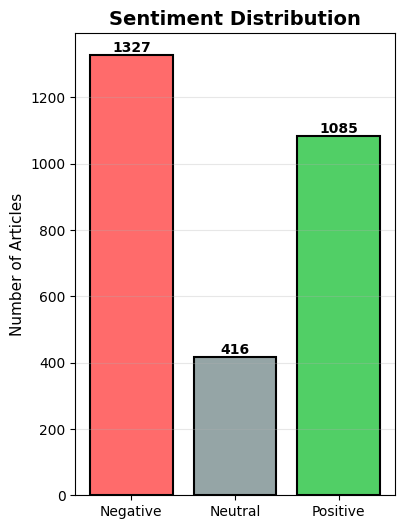

In [71]:
# Cell 26: Visualize distributions
plt.figure(figsize=(14, 6))

# Plot 1: Sentiment distribution
plt.subplot(1, 3, 1)
colors = ['#ff6b6b', '#95a5a6', '#51cf66']
bars = plt.bar(
    ['Negative', 'Neutral', 'Positive'],
    [sentiment_counts.get(-1, 0), sentiment_counts.get(0, 0), sentiment_counts.get(1, 0)],
    color=colors,
    edgecolor='black',
    linewidth=1.5
)
plt.title('Sentiment Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Number of Articles', fontsize=11)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')


In [72]:
# Cell 27: Analyze disagreements
disagreements = [
    a for a in articles 
    if a['headline_sentiment'] != 0 
    and a['content_sentiment'] != 0 
    and a['headline_sentiment'] != a['content_sentiment']
]

print(f"\n⚠️ Found {len(disagreements)} articles with headline-content disagreement")

if disagreements:
    print("\nSample disagreements:")
    print("="*80)
    for i, a in enumerate(disagreements[:3]):
        print(f"\n[{i+1}] {a.get('headline', '')[:70]}...")
        print(f"    Headline: {labels_map[a['headline_sentiment']]}")
        print(f"    Content: {labels_map[a['content_sentiment']]}")
        print(f"    Final: {a['sentiment_label']} (confidence: {a['confidence']})")
        print("-"*80)


⚠️ Found 475 articles with headline-content disagreement

Sample disagreements:

[1] cinq opérations de bloc drainent plus de 26 millions de dinars...
    Headline: Negative
    Content: Positive
    Final: Negative (confidence: 0.624)
--------------------------------------------------------------------------------

[2] sah : réalisation d'une transaction de bloc pour plus de 1,8 million d...
    Headline: Positive
    Content: Negative
    Final: Positive (confidence: 0.34)
--------------------------------------------------------------------------------

[3] la banque de tunisie cède 20.000 actions air liquide tunisie pour 3 mi...
    Headline: Positive
    Content: Negative
    Final: Positive (confidence: 0.531)
--------------------------------------------------------------------------------


In [77]:
# Cell 28: Save enriched articles data
output_file = '../exports/articles_with_sentiment_2021_2026.json'

enriched_data = {
    'metadata': {
        'total_articles': len(articles),
        'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_used': 'xlm-roberta-tunisian-finance',
        'sentiment_distribution': {
            'negative': int(sentiment_counts.get(-1, 0)),
            'neutral': int(sentiment_counts.get(0, 0)),
            'positive': int(sentiment_counts.get(1, 0))
        },
        'confidence_distribution': {
            'high': int(confidence_counts.get('high', 0)),
            'medium': int(confidence_counts.get('medium', 0)),
            'low': int(confidence_counts.get('low', 0))
        },
        'disagreements': len(disagreements)
    },
    'articles': articles
}

with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(enriched_data, f, ensure_ascii=False, indent=2)

print(f"\n✅ Enriched articles saved to: {output_file}")
print(f"   Total size: {len(json.dumps(enriched_data, ensure_ascii=False))} bytes")


✅ Enriched articles saved to: ../exports/articles_with_sentiment_2021_2026.json
   Total size: 6092196 bytes


In [74]:
# Cell 29: Generate ticker-level sentiment aggregation
print("\n" + "="*60)
print("GENERATING TICKER-LEVEL SIGNALS")
print("="*60)

ticker_sentiments = {}

for article in articles:
    # Extract tickers (handle different formats)
    tickers = article.get('tickers', [])
    
    # Convert to list if string
    if isinstance(tickers, str):
        if tickers:
            tickers = [t.strip() for t in tickers.split(',')]
        else:
            tickers = []
    elif not isinstance(tickers, list):
        tickers = []
    
    sentiment = article['sentiment_score']
    confidence = article['confidence']
    date = article.get('date', '')
    
    for ticker in tickers:
        ticker = ticker.strip()
        if not ticker:
            continue
            
        if ticker not in ticker_sentiments:
            ticker_sentiments[ticker] = {
                'ticker': ticker,
                'positive_count': 0,
                'neutral_count': 0,
                'negative_count': 0,
                'total_articles': 0,
                'net_sentiment': 0.0,
                'high_confidence_count': 0,
                'recent_articles': []
            }
        
        stats = ticker_sentiments[ticker]
        stats['total_articles'] += 1
        
        # Count by sentiment
        if sentiment == 1:
            stats['positive_count'] += 1
        elif sentiment == -1:
            stats['negative_count'] += 1
        else:
            stats['neutral_count'] += 1
        
        # Track confidence
        if confidence == 'high':
            stats['high_confidence_count'] += 1
        
        # Store recent article info
        stats['recent_articles'].append({
            'date': date,
            'headline': article.get('headline', '')[:100],
            'sentiment': labels_map[sentiment],
            'confidence': confidence
        })

# Calculate net sentiment scores
for ticker, stats in ticker_sentiments.items():
    if stats['total_articles'] > 0:
        # Net sentiment: (positive - negative) / total
        stats['net_sentiment'] = round(
            (stats['positive_count'] - stats['negative_count']) / stats['total_articles'],
            3
        )
        
        # Keep only 5 most recent articles
        stats['recent_articles'] = sorted(
            stats['recent_articles'],
            key=lambda x: x['date'],
            reverse=True
        )[:5]

print(f"✓ Analyzed {len(ticker_sentiments)} unique tickers")


GENERATING TICKER-LEVEL SIGNALS
✓ Analyzed 15 unique tickers


In [75]:
# Cell 30: Export ticker signals to JSON
signals_output = '../exports/ticker_sentiment_signals.json'

ticker_signals = {
    'generated_at': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model': 'xlm-roberta-tunisian-finance',
    'total_tickers': len(ticker_sentiments),
    'total_articles_analyzed': len(articles),
    'tickers': ticker_sentiments
}

with open(signals_output, 'w', encoding='utf-8') as f:
    json.dump(ticker_signals, f, ensure_ascii=False, indent=2)

print(f"✅ Ticker signals saved to: {signals_output}")

✅ Ticker signals saved to: ../exports/ticker_sentiment_signals.json


In [76]:
# Cell 31: Display top tickers by net sentiment
print("\n" + "="*80)
print("TOP 10 TICKERS BY NET SENTIMENT")
print("="*80)

sorted_tickers = sorted(
    ticker_sentiments.items(),
    key=lambda x: x[1]['net_sentiment'],
    reverse=True
)

for i, (ticker, stats) in enumerate(sorted_tickers[:10], 1):
    print(f"\n{i}. {ticker}")
    print(f"   Total Articles: {stats['total_articles']}")
    print(f"   Positive: {stats['positive_count']} | Neutral: {stats['neutral_count']} | Negative: {stats['negative_count']}")
    print(f"   Net Sentiment: {stats['net_sentiment']:+.3f}")
    print(f"   High Confidence: {stats['high_confidence_count']}/{stats['total_articles']}")

print("\n" + "="*80)
print("BOTTOM 5 TICKERS BY NET SENTIMENT")
print("="*80)

for i, (ticker, stats) in enumerate(sorted_tickers[-5:], 1):
    print(f"\n{i}. {ticker}")
    print(f"   Total Articles: {stats['total_articles']}")
    print(f"   Positive: {stats['positive_count']} | Neutral: {stats['neutral_count']} | Negative: {stats['negative_count']}")
    print(f"   Net Sentiment: {stats['net_sentiment']:+.3f}")


TOP 10 TICKERS BY NET SENTIMENT

1. TELNET HOLDING
   Total Articles: 124
   Positive: 54 | Neutral: 21 | Negative: 49
   Net Sentiment: +0.040
   High Confidence: 0/124

2. STB
   Total Articles: 271
   Positive: 90 | Neutral: 66 | Negative: 115
   Net Sentiment: -0.092
   High Confidence: 0/271

3. BT
   Total Articles: 332
   Positive: 123 | Neutral: 49 | Negative: 160
   Net Sentiment: -0.111
   High Confidence: 0/332

4. BNA
   Total Articles: 444
   Positive: 147 | Neutral: 86 | Negative: 211
   Net Sentiment: -0.144
   High Confidence: 0/444

5. SOTETEL
   Total Articles: 122
   Positive: 45 | Neutral: 10 | Negative: 67
   Net Sentiment: -0.180
   High Confidence: 0/122

6. ATTIJARI BANK
   Total Articles: 522
   Positive: 167 | Neutral: 49 | Negative: 306
   Net Sentiment: -0.266
   High Confidence: 0/522

7. UNIMED
   Total Articles: 164
   Positive: 48 | Neutral: 22 | Negative: 94
   Net Sentiment: -0.280
   High Confidence: 0/164

8. ONE TECH HOLDING
   Total Articles: 235
